In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


### Mô tả 
Bài toán Credit Card Fraud Detection
- Link tải dataset: https://www.kaggle.com/mlg-ulb/creditcardfraud

Đây là một bài toán thuộc lớp bài toán phân loại. Ở bài toán này, chúng ta phải dự đoán đoán thẻ tín dụng 
trong một cuộc giao dịch có phải là giai lận hay không. Bộ dữ liệu này gồm 31 trường dữ liệu trong đó:
- Time: Thời gian tính bằng s giữa giao dịch đầu tiên trong bộ dữ liệu và giao dịch đang xét
- Amount: Số tiền trong giao dịch
- V1, V2, ..., V28: 28 trường được tạo ra bởi thực hiện trích chọn đặc trưng thông qua phép chiếu tuyến tính PCA
- Class: Có phải gian lận hay không

### Target
Dự đoán xem thẻ tín dụng trong một giao dịch có phải gian lận hay không (1 là có, 0 là không)




In [27]:
# Gọi các thư viện cần thiết 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import os
import seaborn as sns
import missingno as msno

# Import các metrics cần thiết
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc, roc_curve, precision_recall_curve, average_precision_score

# Gọi các model cần thiết cho bài toán classification 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import  LogisticRegression

# Sampling
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import ClusterCentroids

from keras.utils import np_utils
from sklearn.preprocessing import StandardScaler

#### Đọc dữ liệu

In [5]:
# Đọc file dữ liệu csv 
data = pd.read_csv(r"/content/gdrive/MyDrive/Teaching Assistant BKHN/week2/data/creditcard.csv")
# Hiển thị 5 samples trong file csv
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
# Miêu tả về các trường số của dữ liệu
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [13]:
null_table = pd.DataFrame(data.isnull().sum()/len(data)*100, index=data.columns, columns=["null ratio"])
null_table

,null ratio
Time,0.0
V1,0.0
V2,0.0
V3,0.0
V4,0.0
V5,0.0
V6,0.0
V7,0.0
V8,0.0
V9,0.0


Số transaction có gian lận tín dụng: 492 và không có gian lận tín dụng: 284315
Tỉ lệ giữa không gian lận và gian lận: 577.8760162601626


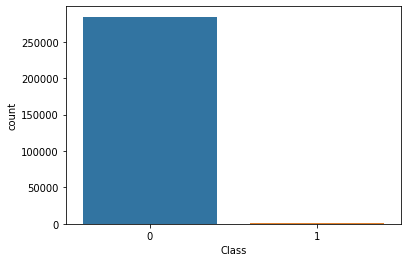

In [14]:
# Vẽ biểu diễn số dữ liệu cho mỗi class
sns.countplot(x= "Class", data= data)
fraud = len(data[data.Class == 1])
no_fraud = len(data[data.Class == 0])

print("Số transaction có gian lận tín dụng: {} và không có gian lận tín dụng: {}".format(fraud, no_fraud))
print("Tỉ lệ giữa không gian lận và gian lận: {}".format(no_fraud/fraud))

In [15]:
# Chia bộ dữ liệu thành 2 phần train và test
seed = 42
X_train, X_test, y_train, y_test = train_test_split(data.drop(["Class"], axis = 1), data["Class"], test_size = 0.3, random_state = seed)

In [16]:
train_data = X_train.copy()
train_data["Class"] = y_train
test_data = X_test.copy()
test_data["Class"] = y_test

train_data.to_csv("train.csv", index = False)
test_data.to_csv("test.csv", index = False)

In [17]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

#### Tìm hiểu dữ liệu

V1, V2, ..., V28 sinh ra do phép chiếu tuyến tính PCA. Xem xét mối quan hệ của Amount, Time với các trường này.

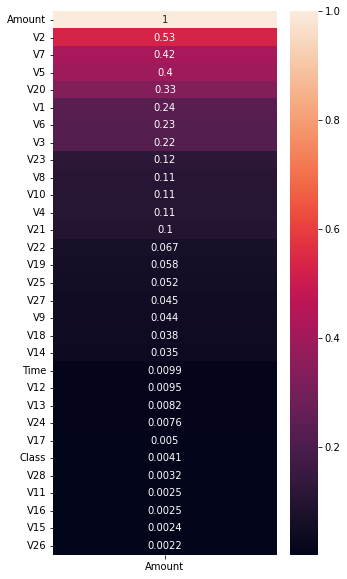

In [18]:
# Tạo ma trận corelation của Amount và Time với các trường

# Tính correlation matrix của cả bộ dataset
correlation_matrix = train_data.corr().abs()
plt.subplots(figsize=(5, 10))
sns.heatmap(correlation_matrix[['Amount']].sort_values(by="Amount", ascending=False), annot=True)
plt.show()


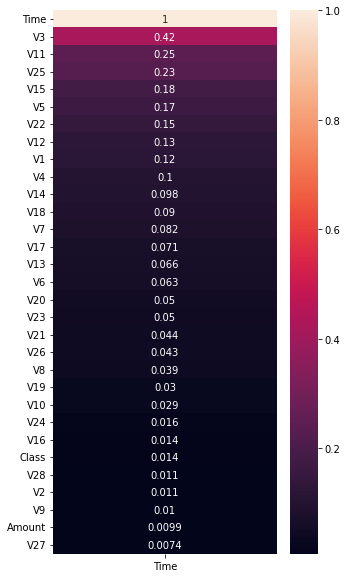

In [19]:
plt.subplots(figsize=(5, 10))
sns.heatmap(correlation_matrix[['Time']].sort_values(by="Time", ascending=False), annot=True)
plt.show()

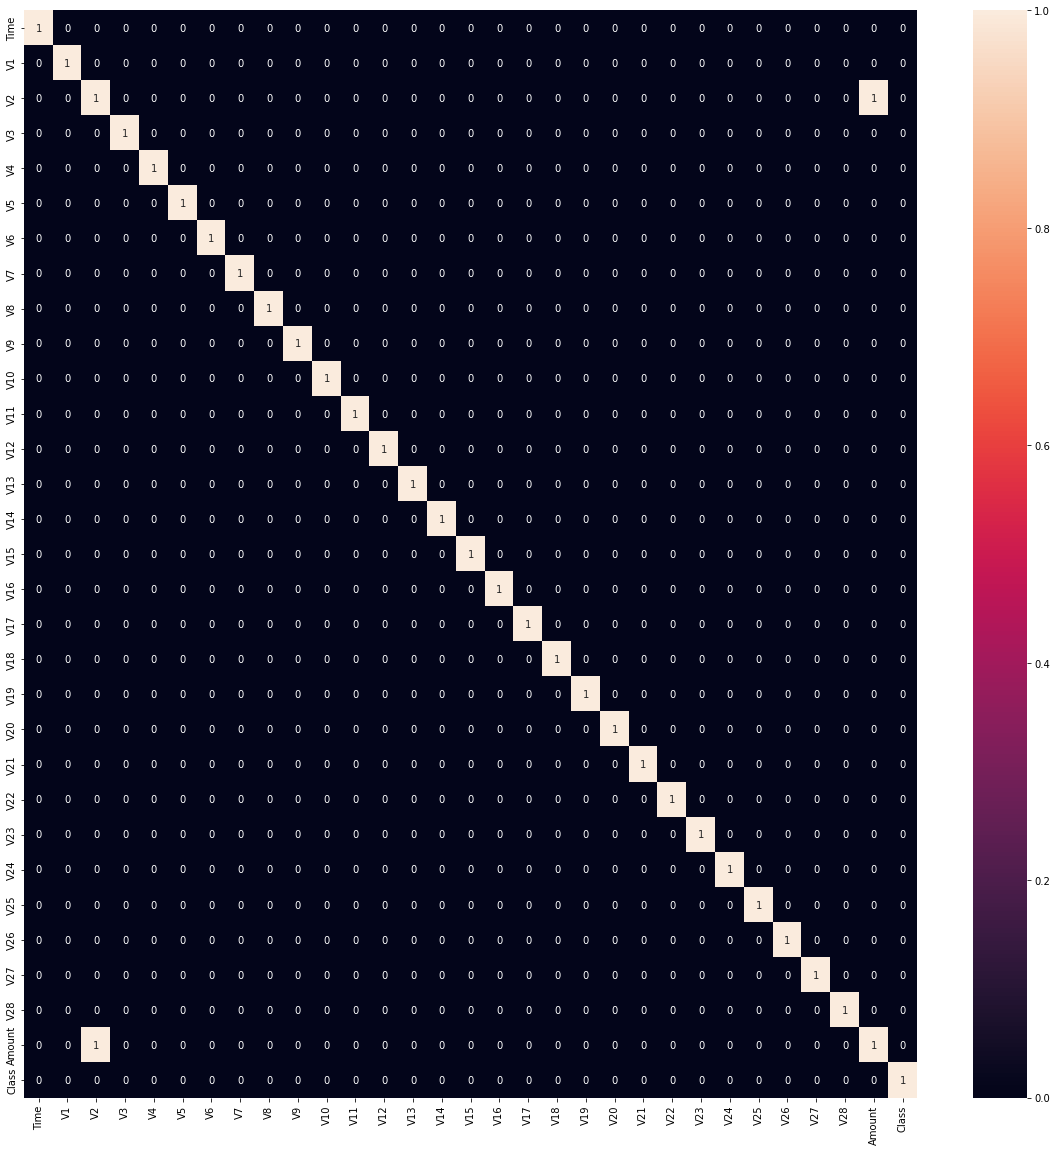

In [22]:
correlation_matrix = np.round(train_data.corr().abs())
plt.subplots(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True)

##### Feature selection: Chúng ta thử sử dụng RandomForest để đánh giá độ quan trọng của các feature trong dataset

In [ ]:
def find_important_feature(X_train, y_train):
    # rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf = GridSearchCV(estimator=RandomForestClassifier(random_state=seed, n_jobs=-1), param_grid={
        'n_estimators': [200, 500, 1000, 2000],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth': [4, 5, 6, 7],
        'criterion': ['entropy']
    }, n_jobs=-1)
    print("Start train")
    rf.fit(X_train, y_train)
    print("End train")
    # Lấy điểm cho các feature
    feature_important = rf.feature_importances_
    im_dict = dict()
    for feature in zip(X_train.columns, feature_important):
        im_dict[feature[0]] = feature[1]
    print("Done")
    return im_dict

# Vẽ đồ thị điểm cho các feature
score = find_important_feature(train_data.drop(["Class"], axis = 1), train_data["Class"])
feature_name = score.keys()
feature_score = score.values()

Start train
End train
Done


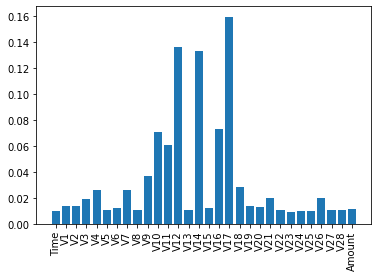

In [ ]:
plt.xticks(rotation=90)
plt.bar(feature_name, feature_score)
plt.show()

In [23]:
logis_model = LogisticRegression()
rf = RandomForestClassifier(random_state=seed)

#### Dùng với dữ liệu gốc

##### Thử với LogisticRegression

In [24]:
# Sử dụng dữ liệu gốc
X, y = train_data.drop(["Class"], axis = 1), train_data["Class"]
X_test, y_test = test_data.drop(["Class"], axis = 1), test_data["Class"]
# Normalize dữ liệu 
scaler = StandardScaler()
transform = scaler.fit(X)
X = transform.transform(X)
X_test = transform.transform(X_test)

Accuracy score: 99.92743700478681 %
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.88      0.63      0.74       136

    accuracy                           1.00     85443
   macro avg       0.94      0.82      0.87     85443
weighted avg       1.00      1.00      1.00     85443



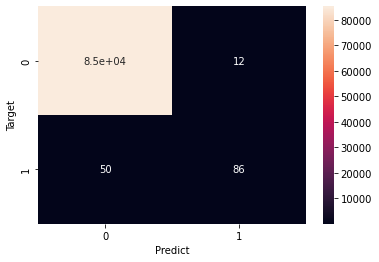

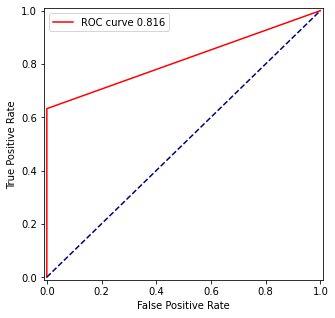

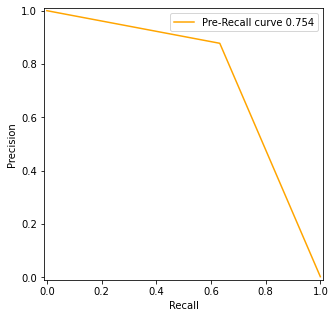

In [25]:
# Sử dụng Logistic Regression

logis_model.fit(X, y)

y_pred = logis_model.predict(X_test)

# In ra accuracy score
print("Accuracy score: {} %".format(accuracy_score(y_test, y_pred)*100))
print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot = True)
plt.ylabel('Target')
plt.xlabel('Predict')
plt.show()

# In ra ROC curve và Precision-Recall curse
precision, recall, thres = precision_recall_curve(y_test, y_pred)
fpr, tpr, thres = roc_curve(y_test, y_pred)

plt.figure(figsize = (5, 5))
plt.plot(fpr, tpr, color = "red", label = "ROC curve %.3f" % auc(fpr, tpr))
plt.axis([-0.01, 1.01, -0.01, 1.01])
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

plt.figure(figsize = (5, 5))
plt.plot(recall, precision, color = "orange", label = "Pre-Recall curve %.3f" % auc(precision, recall))
plt.axis([-0.01, 1.01, -0.01, 1.01])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

##### Thử RandomForest

Accuracy score: 99.96137776061234 %
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.95      0.80      0.87       136

    accuracy                           1.00     85443
   macro avg       0.97      0.90      0.93     85443
weighted avg       1.00      1.00      1.00     85443



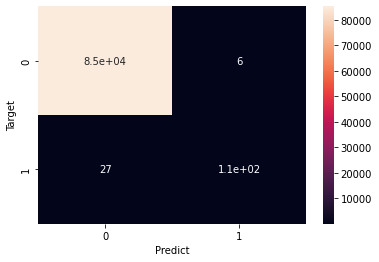

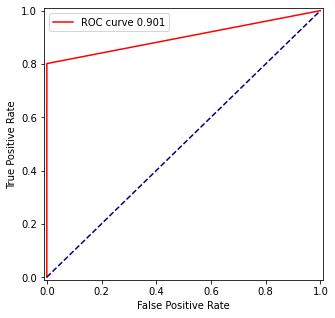

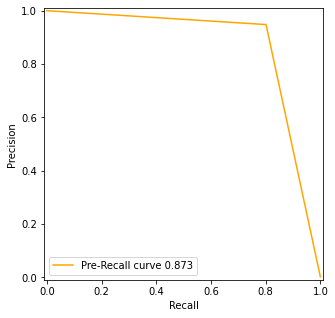

In [26]:
rf.fit(X, y)

y_pred = rf.predict(X_test)

# In ra accuracy score
print("Accuracy score: {} %".format(accuracy_score(y_test, y_pred)*100))
print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot = True)
plt.ylabel('Target')
plt.xlabel('Predict')      
plt.show()

precision, recall, thres = precision_recall_curve(y_test, y_pred)
fpr, tpr, thres = roc_curve(y_test, y_pred)

plt.figure(figsize = (5, 5))
plt.plot(fpr, tpr, color = "red", label = "ROC curve %.3f" % auc(fpr, tpr))
plt.axis([-0.01, 1.01, -0.01, 1.01])
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')                                                                                                                                                    
plt.legend()
plt.show()

plt.figure(figsize = (5, 5))
plt.plot(recall, precision, color = "orange", label = "Pre-Recall curve %.3f" % auc(precision, recall))
plt.axis([-0.01, 1.01, -0.01, 1.01])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

##### Phân tích kết quả trên: 
- Đối với bài toán nhận diện gian lận tín dụng này, ta cần ưu tiên giá trị recall score của class 1 
- Recall = TP/(TP + FN).

Chú thích: 
+ TP: dương tính thật, FP: âm tính bị nhận thành dương tính
+ TN: âm tính thật, FN: dương tính bị nhận thành âm tính

Do đó, vì nếu recall cao tức là cứ hễ có gian lận tín dụng là ta bắt được.
Tuy nhiên, giá trị recall ở kết quả trên khá là thấp với 63%, 80%
--> Cách tiếp cận train model với dữ liệu không cân bằng như này là không khả quan

#### Tìm cách làm cân bằng lại dữ liệu: OverSampling, UnderSampling, SMOTE

##### OverSampling
Phương thức hoạt động là giải pháp này nhân bản một cách ngẫu nhiên các phần tử trong lớp nhỏ hơn để tạo sụ cân bằng dữ liệu
##### UnderSampling
Phương thức hoạt động là giải pháp này sẽ xóa một cách ngẫu nhiên một số phần từ trong lớp lớn hơn để tạo sự cân bằng dữ liệu 
##### SMOTE
Phương thức hoạt động là đầu tiên nó chọn ngẫu nhiên 1 điểm trong tập nhỏ hơn sau đó áp dụng K-nearest-neighbors để tìm các láng giềng gần của nó và tạo ra 1 dữ liệu mới từ đó.

##### UnderSampling

Số transaction có gian lận tín dụng: 356 và không có gian lận tín dụng: 199008
Tỉ lệ giữa không gian lận và gian lận: 559.0112359550562


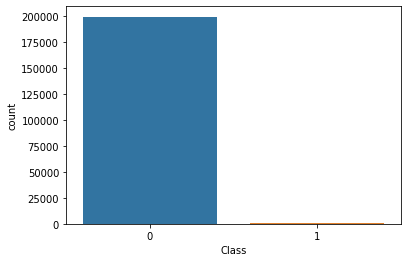

In [ ]:
# Vẽ biểu diễn số dữ liệu cho mỗi class trong train_data
sns.countplot(x= "Class", data= train_data)
fraud = len(train_data[train_data.Class == 1])
no_fraud = len(train_data[train_data.Class == 0])

print("Số transaction có gian lận tín dụng: {} và không có gian lận tín dụng: {}".format(fraud, no_fraud))
print("Tỉ lệ giữa không gian lận và gian lận: {}".format(no_fraud/fraud))

In [ ]:
# Sử dụng dữ liệu gốc
X, y = train_data.drop(["Class"], axis = 1), train_data["Class"]
X_test, y_test = test_data.drop(["Class"], axis = 1), test_data["Class"]

In [ ]:
# Chỉ giữ lại 356 điểm dữ liệu cho class 0:
clus_centroid = ClusterCentroids(sampling_strategy={0: 356})
X_under, y_under = clus_centroid.fit_resample(X, y)

Số transaction có gian lận tín dụng: 356 và không có gian lận tín dụng: 356
Tỉ lệ giữa không gian lận và gian lận: 1.0


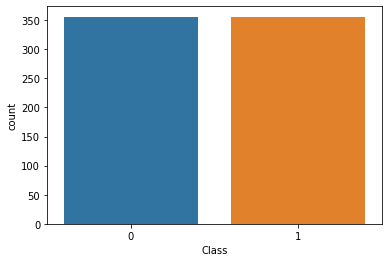

In [ ]:
train = X_under.copy()
train["Class"] = y_under

# Vẽ biểu diễn số dữ liệu cho mỗi class trong train_data
sns.countplot(x= "Class", data= train)
fraud = len(train[train.Class == 1])
no_fraud = len(train[train.Class == 0])

print("Số transaction có gian lận tín dụng: {} và không có gian lận tín dụng: {}".format(fraud, no_fraud))
print("Tỉ lệ giữa không gian lận và gian lận: {}".format(no_fraud/fraud))

In [ ]:
# Normalize dữ liệu 
scaler = StandardScaler()
transform = scaler.fit(X_under)
X_under = transform.transform(X_under)
X_test = transform.transform(X_test)

###### Sử dụng LogisticRegression

Accuracy score: 84.659948737755 %
              precision    recall  f1-score   support

           0       1.00      0.85      0.92     85307
           1       0.01      0.96      0.02       136

    accuracy                           0.85     85443
   macro avg       0.50      0.90      0.47     85443
weighted avg       1.00      0.85      0.92     85443



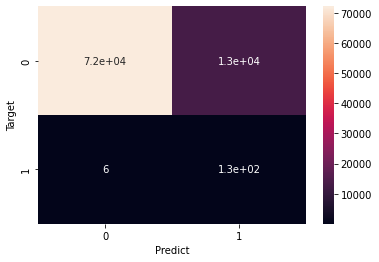

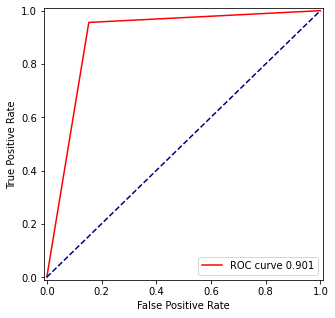

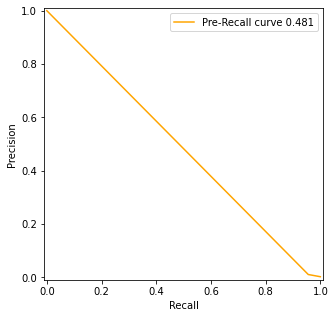

In [ ]:
logis_model_un = LogisticRegression()
logis_model_un.fit(X_under, y_under)

y_pred = logis_model_un.predict(X_test)

# In ra accuracy score
print("Accuracy score: {} %".format(accuracy_score(y_test, y_pred)*100))
print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot = True)
plt.ylabel('Target')
plt.xlabel('Predict')
plt.show()

fpr, tpr, thres = roc_curve(y_test, y_pred)

plt.figure(figsize = (5, 5))
plt.plot(fpr, tpr, color = "red", label = "ROC curve %.3f" % auc(fpr, tpr))
plt.axis([-0.01, 1.01, -0.01, 1.01])
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

precision, recall, thres = precision_recall_curve(y_test, y_pred)
plt.figure(figsize = (5, 5))
plt.plot(recall, precision, color = "orange", label = "Pre-Recall curve %.3f" % auc(precision, recall))
plt.axis([-0.01, 1.01, -0.01, 1.01])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()


##### Sử dụng RandomForest

Accuracy score: 13.289561462027317 %
              precision    recall  f1-score   support

           0       1.00      0.13      0.23     85307
           1       0.00      1.00      0.00       136

    accuracy                           0.13     85443
   macro avg       0.50      0.57      0.12     85443
weighted avg       1.00      0.13      0.23     85443



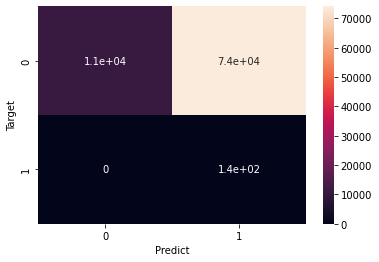

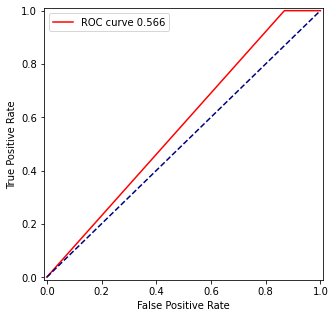

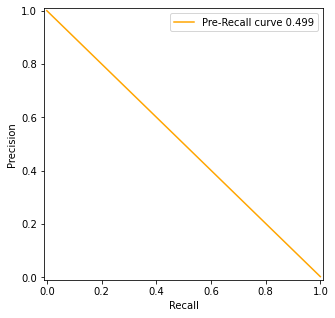

In [ ]:
rf_un = RandomForestClassifier(n_estimators=100, random_state=seed)
rf_un.fit(X_under, y_under)

y_pred = rf_un.predict(X_test)

# In ra accuracy score
print("Accuracy score: {} %".format(accuracy_score(y_test, y_pred)*100))
print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot = True)
plt.ylabel('Target')
plt.xlabel('Predict')
plt.show()

fpr, tpr, thres = roc_curve(y_test, y_pred)

plt.figure(figsize = (5, 5))
plt.plot(fpr, tpr, color = "red", label = "ROC curve %.3f" % auc(fpr, tpr))
plt.axis([-0.01, 1.01, -0.01, 1.01])
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

precision, recall, thres = precision_recall_curve(y_test, y_pred)
plt.figure(figsize = (5, 5))
plt.plot(recall, precision, color = "orange", label = "Pre-Recall curve %.3f" % auc(precision, recall))
plt.axis([-0.01, 1.01, -0.01, 1.01])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

##### Sử dụng SMOTE

In [ ]:
X, y = train_data.drop(["Class"], axis = 1), train_data["Class"]
X_test, y_test = test_data.drop(["Class"], axis = 1), test_data["Class"]

In [ ]:
smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_resample(X, y)

Số transaction có gian lận tín dụng: 199008 và không có gian lận tín dụng: 199008
Tỉ lệ giữa không gian lận và gian lận: 1.0


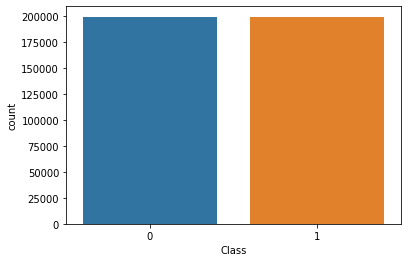

In [ ]:
train = X_sm.copy()
train["Class"] = y_sm

# Vẽ biểu diễn số dữ liệu cho mỗi class trong train_data
sns.countplot(x= "Class", data= train)
fraud = len(train[train.Class == 1])
no_fraud = len(train[train.Class == 0])

print("Số transaction có gian lận tín dụng: {} và không có gian lận tín dụng: {}".format(fraud, no_fraud))
print("Tỉ lệ giữa không gian lận và gian lận: {}".format(no_fraud/fraud))

In [ ]:
# Normalize dữ liệu 
scaler = StandardScaler()
transform = scaler.fit(X_sm)
X_sm = transform.transform(X_sm)
X_test = transform.transform(X_test)

### Sử dụng LogisticRegression

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Accuracy score: 99.07189588380558 %
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     85307
           1       0.14      0.93      0.24       136

    accuracy                           0.99     85443
   macro avg       0.57      0.96      0.62     85443
weighted avg       1.00      0.99      0.99     85443



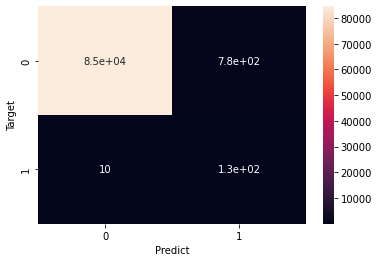

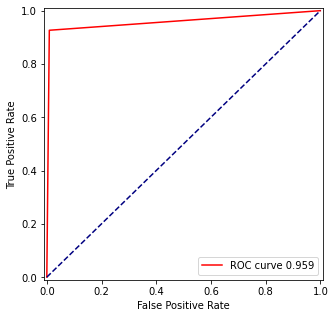

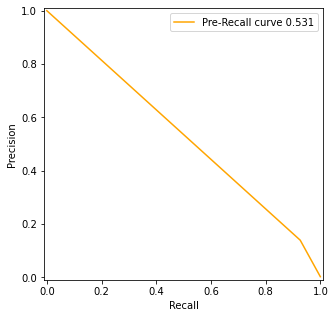

In [ ]:
logis_model_sm = LogisticRegression()
logis_model_sm.fit(X_sm, y_sm)

y_pred = logis_model_sm.predict(X_test)

# In ra accuracy score
print("Accuracy score: {} %".format(accuracy_score(y_test, y_pred)*100))
print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot = True)
plt.ylabel('Target')
plt.xlabel('Predict')
plt.show()
fpr, tpr, thres = roc_curve(y_test, y_pred)

plt.figure(figsize = (5, 5))
plt.plot(fpr, tpr, color = "red", label = "ROC curve %.3f" % auc(fpr, tpr))
plt.axis([-0.01, 1.01, -0.01, 1.01])
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

precision, recall, thres = precision_recall_curve(y_test, y_pred)
plt.figure(figsize = (5, 5))
plt.plot(recall, precision, color = "orange", label = "Pre-Recall curve %.3f" % auc(precision, recall))
plt.axis([-0.01, 1.01, -0.01, 1.01])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

#### Sử dụng RandomForest

Accuracy score: 99.9531851643786 %
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.84      0.88      0.86       136

    accuracy                           1.00     85443
   macro avg       0.92      0.94      0.93     85443
weighted avg       1.00      1.00      1.00     85443



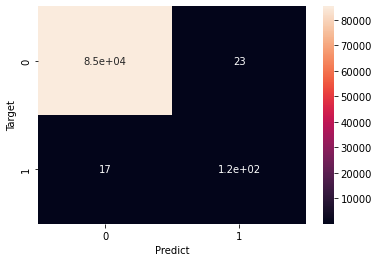

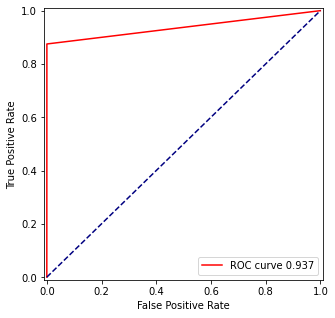

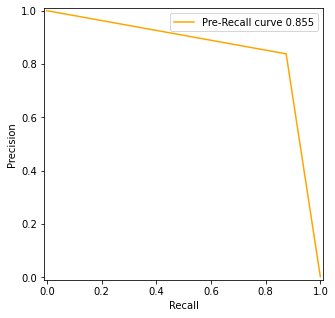

In [ ]:
rf_sm = RandomForestClassifier(random_state=seed)
rf_sm.fit(X_sm, y_sm)

y_pred = rf_sm.predict(X_test)

# In ra accuracy score
print("Accuracy score: {} %".format(accuracy_score(y_test, y_pred)*100))
print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot = True)
plt.ylabel('Target')
plt.xlabel('Predict')
plt.show()

fpr, tpr, thres = roc_curve(y_test, y_pred)

plt.figure(figsize = (5, 5))
plt.plot(fpr, tpr, color = "red", label = "ROC curve %.3f" % auc(fpr, tpr))
plt.axis([-0.01, 1.01, -0.01, 1.01])
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

precision, recall, thres = precision_recall_curve(y_test, y_pred)
plt.figure(figsize = (5, 5))
plt.plot(recall, precision, color = "orange", label = "Pre-Recall curve %.3f" % auc(precision, recall))
plt.axis([-0.01, 1.01, -0.01, 1.01])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()